In [3]:
import sys 
from scipy.interpolate import RegularGridInterpolator


sys.path.append("/users/tom/git/neon_blink_detection/")
sys.path.append("/users/tom/git/neon_blink_detection/src")

from src.features_calculator import create_grids
import numpy as np

from training.video_loader import video_loader
from src.helper import OfParams, AugParams
of_params = OfParams()
aug_params = AugParams()

clip_name = "1322-2023-02-03-14-25-41-7883a14f"

of_params = OfParams(n_layers=3, layer_interval=7, average=False, img_shape=(64, 64), grid_size=15, step_size=5, window_size=11, stop_steps=3)

rec = video_loader(of_params, aug_params)

rec._load_legacy(clip_name, bg_ratio=3)


Number of clips: 2


In [4]:
feature_array, all_timestamps, clip_transitions = rec._load_features(
            clip_name, rec._of_params)

# Add random sampling of some indicies
n_clips = clip_transitions.shape[0] + 1
clip_feature_array = np.split(feature_array, clip_transitions + 1, axis=0)
clip_timestamps = np.split(all_timestamps, clip_transitions + 1, axis=0)

# only take y direction
feature_array = clip_feature_array[0][:, :, 1]
timestamps = clip_timestamps[0]
t = (timestamps - timestamps[0]) / 1e9

of_left = np.reshape(feature_array[:, :400], (-1,20,20))
of_right = np.reshape(feature_array[:, 400:], (-1,20,20))

Number of clips: 2


In [5]:
timestamps, eye_left_images, eye_right_images = rec._get_frames(clip_name, convert_to_gray=True)

t = (timestamps - timestamps[0]) / 1e9

# where difference in frames is larger than 100 ms
clip_transitions = np.where(np.diff(timestamps) > 1e8)[0]

n_clips = clip_transitions.shape[0] + 1
clip_left_images = np.split(eye_left_images, clip_transitions + 1)
clip_right_images = np.split(eye_right_images, clip_transitions + 1)

feature_array = []

for iclip in range(0, n_clips):

    clip_feature_array, grid = rec._compute_optical_flow(
        of_params, clip_left_images[iclip], clip_right_images[iclip]
    )

    feature_array.append(clip_feature_array)

feature_array = np.vstack(feature_array)

deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly


deprecated pixel format used, make sure you did set range correctly
 (repeated 11834 more times)
deprecated pixel format used, make sure you did set range correctly


In [157]:
feature_array = feature_array[:, :, 1]

of_left = np.reshape(feature_array[:, :400], (-1,20,20))
of_right = np.reshape(feature_array[:, 400:], (-1,20,20))

In [10]:
feature_array, all_timestamps, clip_transitions = rec._load_features(
            clip_name, rec._of_params)

feature_array

Number of clips: 2


array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [-0.16474533, -0.0471611 ],
        [-0.14723206, -0.1602974 ],
        [ 0.13716125, -0.3570366 ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [-0.02874756,  0.08181763],
        [ 0.18031693, -0.14967346],
        [ 0.55955505, -0.6081848 ]],

       ...,

       [[ 0.04804516, -0.141963  ],
        [ 0.07432699,  0.01540279],
        [ 0.0310607 ,  0.07298088],
        ...,
        [ 0.38268661, -0.61286545],
        [ 0.5335121 , -0.5540314 ],
        [ 0.10185242, -0.34669876]],

       [[ 0.2539587 , -0.4475913 ],
        [ 0.1213541 , -0.27

In [8]:
import typing as T

def new_concatenate_features(
    feature_array: np.ndarray, of_params: OfParams, indices: np.ndarray = None
) -> np.ndarray:
    
    def get_layers(n, layer_interval):
        return np.arange(-(n // 2), (n + 1) // 2) * layer_interval
    
    interp_left, interp_right = _create_interpolater(feature_array)
    
    print(of_params)
    print(of_params.layer_interval)
    layer_interval = of_params.layer_interval / 200 # sampling rate to convert to ms

    n_frame = len(feature_array)

    if indices is None:
        indices = np.arange(n_frame) / 200

    n_grids = of_params.grid_size * of_params.grid_size * 2
    layers = get_layers(of_params.n_layers, layer_interval)

    indices_layers = np.array([[indices + i] for i in layers]).reshape(len(layers), -1)
    indices_layers = np.clip(indices_layers, 0, len(feature_array) - 1)

    features_left = np.concatenate([interpolate_spacetime(interp_left, indices, grid_size=of_params.grid_size).reshape(-1, of_params.grid_size**2) for indices in indices_layers], axis=-1)

    features_right = np.concatenate([interpolate_spacetime(interp_right, indices, grid_size=of_params.grid_size).reshape(-1, of_params.grid_size**2) for indices in indices_layers], axis=-1)

    return np.concatenate((features_left, features_right), axis=-1)

def _create_interpolater(feature_array: np.ndarray, grid_size=20):

    length = grid_size ** 2

    of_left = np.reshape(feature_array[:, :length], (-1, grid_size, grid_size))
    of_right = np.reshape(feature_array[:, length:], (-1, grid_size, grid_size))

    x = np.linspace(0, 64, grid_size, dtype=np.float32)
    y = np.linspace(0, 64, grid_size, dtype=np.float32)

    interpolator_left = RegularGridInterpolator((t, x, y), of_left, bounds_error=False, fill_value=None, method="linear")
    
    interpolator_right = RegularGridInterpolator((t, x, y), of_right, bounds_error=False, fill_value=None, method="linear")

    return interpolator_left, interpolator_right


def interpolate_spacetime(interpolator, time_points: T.List[int], grid_size: int, augmentation: T.Dict[str, int] = None):
    
    x = np.linspace(0, 64, grid_size + 2, dtype=np.float32)[1:-1]
    y = np.linspace(0, 64, grid_size + 2, dtype=np.float32)[1:-1]

    tt, xx, yy = np.meshgrid(time_points, x, y)

    txy_grid = np.concatenate((tt.reshape(-1, 1), xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    if augmentation is not None:

        augm_params = get_augmentation_pars()

        grid_trans = np.zeros_like(txy_grid)

        grid_trans = txy_grid[:, 0]
        grid_trans[:, 1:] = (augm_params["linear_distort"] @ (augm_params["scale"] * (txy_grid[:, 1:] - 32.)).T).T + 32 + augm_params["translation"]

        txy_grid = grid_trans
    
    return interpolator(txy_grid).reshape(grid_size, len(time_points), grid_size).transpose(1, 0, 2)
    
def get_augmentation_pars(n_augmentations):
    
    augmentation_params = {}
    
    std_speed = 0.2
    std_translation = 3
    std_scale = 0.15
    std_linear = 0.03
    
    augmentation_params["speed"] = np.random.normal(1, std_speed, n_augmentations)
    augmentation_params["translation"] = np.random.normal(0, std_translation, (n_augmentations, 2))
    augmentation_params["scale"] = np.random.normal(1, std_scale, n_augmentations)
    augmentation_params["linear_distort"] = np.squeeze(np.dstack([np.eye(2)]*n_augmentations) + np.random.normal(0, std_linear, (2, 2, n_augmentations)))
    
    return augmentation_params


In [9]:
np.random.normal(1, 0.1)

1.0620881393362114

**Interpolate to 50x50 grid for 3 points in time**

*Plot result*

In [ ]:
# import matplotlib.pyplot as plt

# interp_left, interp_right = _create_interpolater(feature_array)

# of_interp = interpolate_spacetime(interp_left, t, grid_size=20)

# f, ax = plt.subplots(1, 2, figsize=(10, 5))

# ax[0].imshow(of_interp[5,:, :])
# ax[0].set_title("Interpolated")
                

# augm_params = get_augmentation_pars()

# p_grid = create_grids((64,64), 20 + 2, full_grid=False) 
# p_grid_trans = np.empty_like(p_grid)
# p_grid_trans = (linear_distort @ (scale * (p_grid - 32.)).T).T + 32 + translation

# of_interp = interpolate_spacetime(interp_left, t, grid_size=20, x=p_grid_trans[:, 0], y=p_grid_trans[:, 1])


# ax[1].imshow(of_interp[5, :, :])
# ax[1].set_title("Distorted")



In [248]:
x = np.linspace(0, 64, 20 + 2, dtype=np.float32)[1:-1]
y = np.linspace(0, 64, 20 + 2, dtype=np.float32)[1:-1]

tt, xx, yy = np.meshgrid(t, x, y)

txy_grid = np.concatenate((tt.reshape(-1, 1), xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

In [7]:
import matplotlib.pyplot as plt
from src.features_calculator import (
    new_concatenate_features,
    get_augmentation_pars,
)

rec._of_params.grid_size = 4
rec._of_params.n_layers = 7

feature_array, all_timestamps, clip_transitions = rec._load_features(
            clip_name, rec._of_params)

# Add random sampling of some indicies

n_clips = clip_transitions.shape[0] + 1
clip_feature_array = np.split(feature_array, clip_transitions + 1, axis=0)
clip_timestamps = np.split(all_timestamps, clip_transitions + 1, axis=0)


Number of clips: 2


**Generate artificial feature array**

In [9]:
of_left = np.zeros([3490, 20, 20, 2])
of_left[:, 6:14, 6:14, :] = 1

of_right = np.zeros([3490, 20, 20, 2])
of_right[:, 6:14, 6:14, :] = 1

of_left = of_left.reshape(-1, 20*20, 2)
of_right = of_right.reshape(-1, 20*20, 2)

feature_array = np.concatenate((of_left, of_right), axis=1)

**Plot features with and without augmentation**

options 100


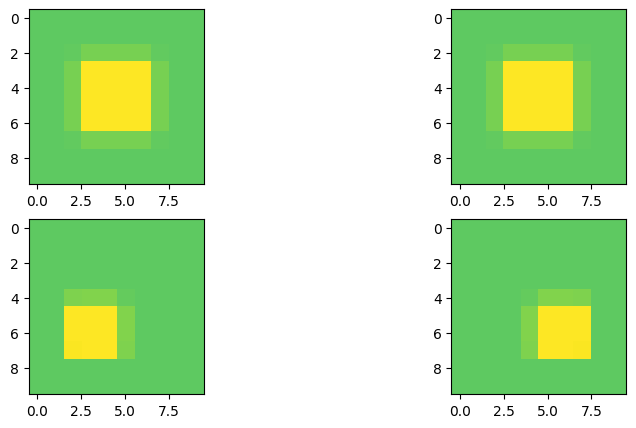

In [38]:
rec._of_params.grid_size = 10
rec._of_params.n_layers = 7

from src.features_calculator import (
    new_concatenate_features,
    get_augmentation_pars,
    create_interpolater
)
from training.helper import get_augmentation_options
import matplotlib.pyplot as plt

iclip = 1

all_times = (all_timestamps[0:10000] - all_timestamps[0]) / 1e9 
indc_times = [2, 500, 1000, 2000, 5000, 10000]

interp_left, interp_right = create_interpolater(feature_array[:, :, 1], all_times)
n_clip_frames = clip_feature_array[iclip].shape[0]

aug_params_options = get_augmentation_options()
aug_options = aug_params_options[0]
aug_params = get_augmentation_pars(aug_options)

aug_params["speed"] = 1
aug_params["translation"] = np.zeros((1, 2))
aug_params["scale"] = 1
aug_params["linear_distort"] = np.eye(2)

aug_feat = new_concatenate_features(
    interp_left,
    interp_right,
    n_clip_frames,
    of_params,
    indc_times[0],
    aug_params,
)

# print(aug_feat.shape)
left = aug_feat[0, :700].reshape(7, 10, 10)
right = aug_feat[0, 700:].reshape(7, 10, 10)

# for aug_params in aug_params_options:
    
aug_params = {}
aug_params["speed"] = 1
aug_params["translation"] = [-10, 10]
aug_params["scale"] = 1.5
aug_params["linear_distort"] = np.eye(2) + [[0, 0], [0, 0]]

aug_feat = new_concatenate_features(
    interp_left,
    interp_right,
    n_clip_frames,
    of_params,
    indc_times[0],
    aug_params,
)

left_aug = aug_feat[0, :700].reshape(7, 10, 10)
right_aug = aug_feat[0, 700:].reshape(7, 10, 10)


f, ax = plt.subplots(2, 2, figsize=(10, 5))

ax[0, 0].imshow(left[0, :, :], vmin=-3, vmax=1)
ax[0, 1].imshow(right[0, :, :], vmin=-3, vmax=1)
ax[1, 0].imshow(left_aug[0, :, :], vmin=-3, vmax=1)
ax[1, 1].imshow(right_aug[0, :, :], vmin=-3, vmax=1)

(1, 1400)

In [10]:
import matplotlib.pyplot as plt
from src.features_calculator import (
    new_concatenate_features,
    get_augmentation_pars,
)

rec._of_params.grid_size = 4
rec._of_params.n_layers = 7

feature_array, all_timestamps, clip_transitions = rec._load_features(
            clip_name, rec._of_params)

# Add random sampling of some indicies

n_clips = clip_transitions.shape[0] + 1
clip_feature_array = np.split(feature_array, clip_transitions + 1, axis=0)
clip_timestamps = np.split(all_timestamps, clip_transitions + 1, axis=0)


Number of clips: 2


In [36]:
from src.features_calculator import (
    new_concatenate_features,
    get_augmentation_pars,
    create_interpolater
)
from training.helper import get_augmentation_options
import matplotlib.pyplot as plt

all_times = (all_timestamps[0:10000] - all_timestamps[0]) / 1e9 
indc_times = [2, 500, 1000, 2000, 5000, 10000]

interp_left, interp_right = create_interpolater(feature_array[:, :, 1], all_times)
n_clip_frames = clip_feature_array[iclip].shape[0]

# aug_params_options = get_augmentation_options()
# aug_options = aug_params_options[0]
# aug_params = get_augmentation_pars(aug_options)

vec = np.zeros([224, 24])
aug_params = {}

aug_params["speed"] = 1
aug_params["translation"] = np.zeros((1, 2))
aug_params["scale"] = 1
aug_params["linear_distort"] = np.eye(2)

aug_feat = new_concatenate_features(
    interp_left,
    interp_right,
    n_clip_frames,
    of_params,
    indc_times[2],
    aug_params,
)

# print(aug_feat.shape)
# left = aug_feat[0, :112].reshape(7, 4, 4)
# right = aug_feat[0, 112:].reshape(7, 4, 4)

vec[:, 0] = aug_feat

for i, all_aug_params in enumerate(aug_params_options):

    aug_params["speed"] = 1
    aug_params["translation"] = [0, all_aug_params.std_translation]
    aug_params["scale"] = 1 + all_aug_params.std_scale
    aug_params["linear_distort"] = np.eye(2) + [[0, 0], [0, 0]]

    aug_feat = new_concatenate_features(
        interp_left,
        interp_right,
        n_clip_frames,
        of_params,
        indc_times[0],
        aug_params,
    )
    
    vec[:, i] = aug_feat

    # left_aug = aug_feat[0, :112].reshape(7, 4, 4)
    # right_aug = aug_feat[0, 112:].reshape(7, 4, 4)


    # f, ax = plt.subplots(2, 2, figsize=(10, 5))

    # ax[0, 0].imshow(left[0, :, :], vmin=-3, vmax=1)
    # ax[0, 1].imshow(right[0, :, :], vmin=-3, vmax=1)
    # ax[1, 0].imshow(left_aug[0, :, :], vmin=-3, vmax=1)
    # ax[1, 1].imshow(right_aug[0, :, :], vmin=-3, vmax=1)

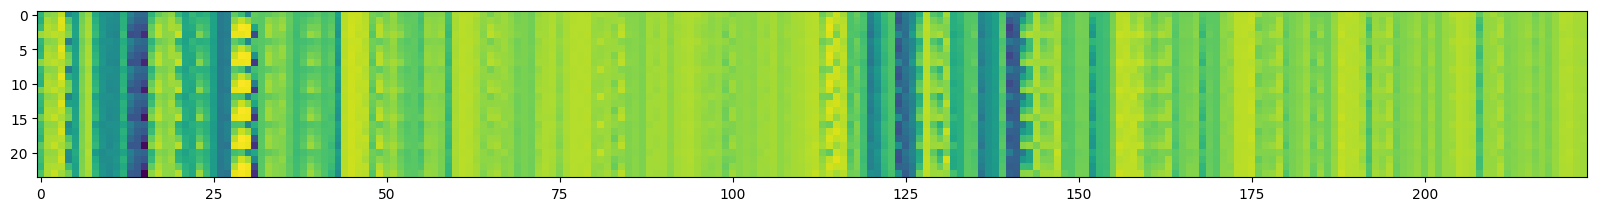

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.set_size_inches(20, 30)
plt.imshow(vec.transpose())


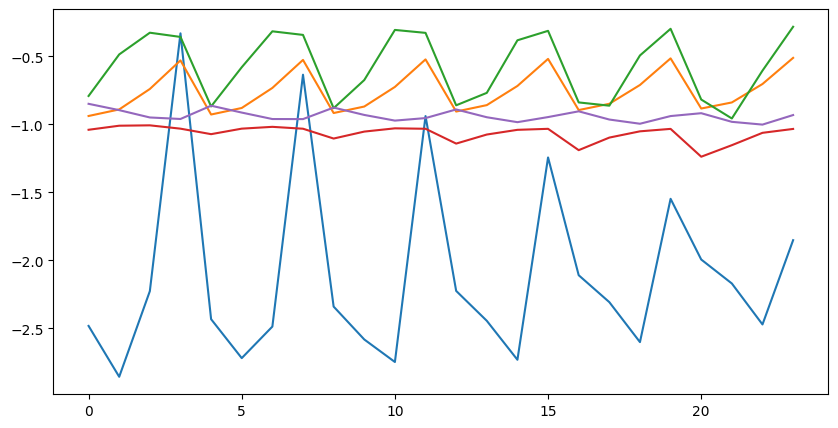

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(vec[[0, 50, 100, 150, 200], :].transpose())

array([-4.17367137, -2.38078565, -4.5744855 , -1.55344403, -0.93807524,
       -0.13177542, -0.90270045, -0.33760561, -0.790868  , -4.8060915 ])

In [122]:
aug_feat.shape

(1, 224)

0.3